In [42]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

pd.read_csv(r"C:/Users/emmae/OneDrive/Desktop/econometrics-fall/Project/smokefree.csv")

# If your notebook is in the same folder as the CSVs, this is enough:
smoke_laws = pd.read_csv("smokefree.csv")
brfss = pd.read_csv("tobacco_use.csv")

# Take a look at column names so we can match them
print("Smoke law columns:")
print(smoke_laws.columns.tolist())
print("\nBRFSS columns:")
print(brfss.columns.tolist())

Smoke law columns:
['Year', 'Quarter', 'LocationAbbr', 'LocationDesc', 'TopicDesc', 'MeasureDesc', 'DataSource', 'ProvisionGroupDesc', 'ProvisionDesc', 'ProvisionValue', 'Citation', 'ProvisionAltValue', 'DataType', 'Comments', 'Enacted_Date', 'Effective_Date', 'GeoLocation', 'DisplayOrder', 'TopicTypeId', 'TopicId', 'MeasureId', 'ProvisionGroupID', 'ProvisionID']

BRFSS columns:
['Year', 'State', 'Smoke everyday', 'Smoke some days', 'Former smoker', 'Never smoked', 'Location 1']


In [43]:
smoke_laws.columns.tolist()

['Year',
 'Quarter',
 'LocationAbbr',
 'LocationDesc',
 'TopicDesc',
 'MeasureDesc',
 'DataSource',
 'ProvisionGroupDesc',
 'ProvisionDesc',
 'ProvisionValue',
 'Citation',
 'ProvisionAltValue',
 'DataType',
 'Comments',
 'Enacted_Date',
 'Effective_Date',
 'GeoLocation',
 'DisplayOrder',
 'TopicTypeId',
 'TopicId',
 'MeasureId',
 'ProvisionGroupID',
 'ProvisionID']

In [44]:
#Clean BRFSS and compute smoking rate
import pandas as pd
import numpy as np

# assuming you've already done:
# brfss = pd.read_csv("tobacco_use.csv")

# 1. Make a copy so we don't accidentally overwrite
brfss_clean = brfss.copy()

# 2. Ensure the smoking columns are numeric (strip % signs if they exist)
smoke_cols = ["Smoke everyday", "Smoke some days", "Former smoker", "Never smoked"]

for col in smoke_cols:
    brfss_clean[col] = (
        brfss_clean[col]
        .astype(str)
        .str.replace("%", "", regex=False)
    )
    brfss_clean[col] = pd.to_numeric(brfss_clean[col], errors="coerce")

# 3. Define CURRENT SMOKER rate: Smoke everyday + Smoke some days
brfss_clean["smoking_rate"] = (
    brfss_clean["Smoke everyday"] + brfss_clean["Smoke some days"]
)

# 4. Keep just what we need: state-year + smoking_rate
smoking_panel = (
    brfss_clean[["Year", "State", "smoking_rate"]]
    .rename(columns={"Year": "year", "State": "state"})
)

smoking_panel.head()
smoking_panel.describe()

,year,smoking_rate
count,876.000000,876.000000
mean,2002.591324,21.394977
std,4.593622,4.007173
min,1995.000000,5.800000
25%,1999.000000,19.275000
50%,2003.000000,21.800000
75%,2007.000000,23.825000
max,2010.000000,34.100000


In [45]:
#build policy panel
smoke_laws["ProvisionDesc"].unique()[:40]

array(['Enforcement (Type)', 'Enforcement Authority', 'Signage Required',
       'Maximum Penalty ($)', 'Type of Restriction in Bar Patron Area',
       'Penalty to Business (Type)',
       'Type of Restriction in Bar Employee Area',
       'Type of Restriction in Bar (Summary)',
       'Distance From Entrances/Exits (ft)', 'Penalty to Smoker',
       'Penalty to Business', 'Minimum Penalty ($)',
       'Type of Restriction in Private Worksite Vehicle',
       'Written Policy\xa0Required',
       'Minimum Number of Employees Required', 'Level of Offense',
       'Type of Restriction in Private Worksite',
       'Requires More Than One Person in Vehicle',
       'Non-Retaliation\xa0Provision',
       'Minimum Number\xa0of Employees\xa0Required (#)',
       'Type of Restriction in Restaurant (Summary)',
       'Minimum\xa0Seating Capacity (#)',
       'Type of Restriction in Restaurant Bar Area',
       'Percent Smokefree Seating',
       'Type of Restriction in Restaurant Patron Area',


In [46]:
smoke_laws["MeasureDesc"].unique()[:40]

array(['Bars', 'Private Worksites', 'Restaurants'], dtype=object)

In [47]:
smoke_laws[
    smoke_laws["ProvisionDesc"].str.contains("Type of Restriction", case=False, na=False)
][["MeasureDesc", "ProvisionDesc", "ProvisionValue", "ProvisionAltValue"]].head(20)

,MeasureDesc,ProvisionDesc,ProvisionValue,ProvisionAltValue
4,Bars,Type of Restriction in Bar Patron Area,NaN,1
6,Bars,Type of Restriction in Bar Employee Area,NaN,1
7,Bars,Type of Restriction in Bar (Summary),NaN,1
14,Private Worksites,Type of Restriction in Private Worksite Vehicle,No Provision,0
21,Private Worksites,Type of Restriction in Private Worksite,Designated Areas,3
29,Restaurants,Type of Restriction in Restaurant (Summary),NaN,1
31,Restaurants,Type of Restriction in Restaurant Bar Area,NaN,1
36,Restaurants,Type of Restriction in Restaurant Patron Area,NaN,1
37,Restaurants,Type of Restriction in Restaurant Employee Area,NaN,1
45,Bars,Type of Restriction in Bar Patron Area,No Provision,0


In [48]:
policy = smoke_laws.copy()

# Keep only the relevant summary restriction rows
summary_policy = policy[
    policy["ProvisionDesc"].str.contains("Summary", case=False, na=False) |
    policy["ProvisionDesc"].str.contains("Private Worksite", case=False, na=False)
]

In [49]:
#bars policy table
bars = smoke_laws[
    (smoke_laws["MeasureDesc"] == "Bars") &
    (smoke_laws["ProvisionDesc"].str.contains("Bar (Summary)", case=False, na=False))
][["Year", "LocationAbbr", "ProvisionValue"]].copy()

bars["ProvisionValue"] = pd.to_numeric(bars["ProvisionValue"], errors="coerce")
bars["bar_ban"] = (bars["ProvisionValue"] == 1).astype(int)

bars = bars[["Year", "LocationAbbr", "bar_ban"]]

C:\Users\emmae\AppData\Local\Temp\ipykernel_16608\1639465244.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  (smoke_laws["ProvisionDesc"].str.contains("Bar (Summary)", case=False, na=False))


In [50]:
#restaurant policy table
restaurants = smoke_laws[
    (smoke_laws["MeasureDesc"] == "Restaurants") &
    (smoke_laws["ProvisionDesc"].str.contains("Restaurant (Summary)", case=False, na=False))
][["Year", "LocationAbbr", "ProvisionValue"]].copy()

restaurants["ProvisionValue"] = pd.to_numeric(restaurants["ProvisionValue"], errors="coerce")
restaurants["rest_ban"] = (restaurants["ProvisionValue"] == 1).astype(int)

restaurants = restaurants[["Year", "LocationAbbr", "rest_ban"]]

C:\Users\emmae\AppData\Local\Temp\ipykernel_16608\2252297628.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  (smoke_laws["ProvisionDesc"].str.contains("Restaurant (Summary)", case=False, na=False))


In [51]:
#worksite policy table
worksites = smoke_laws[
    (smoke_laws["MeasureDesc"] == "Private Worksites") &
    (smoke_laws["ProvisionDesc"].str.contains("Private Worksite", case=False, na=False))
][["Year", "LocationAbbr", "ProvisionValue"]].copy()

worksites["ProvisionValue"] = pd.to_numeric(worksites["ProvisionValue"], errors="coerce")
worksites["work_ban"] = (worksites["ProvisionValue"] == 1).astype(int)

worksites = worksites[["Year", "LocationAbbr", "work_ban"]]

In [52]:
#merge
policy_panel = (
    bars
    .merge(restaurants, on=["Year", "LocationAbbr"], how="outer")
    .merge(worksites,   on=["Year", "LocationAbbr"], how="outer")
)

# Rename to match smoking_panel
policy_panel = policy_panel.rename(columns={
    "Year": "year",
    "LocationAbbr": "state"
})

# Treat missing bans as 0 (no law)
for col in ["bar_ban", "rest_ban", "work_ban"]:
    policy_panel[col] = policy_panel[col].fillna(0).astype(int)

# Comprehensive ban if all three = 1
policy_panel["comprehensive_ban"] = (
    (policy_panel["bar_ban"]  == 1) &
    (policy_panel["rest_ban"] == 1) &
    (policy_panel["work_ban"] == 1)
).astype(int)

policy_panel.tail()

,year,state,bar_ban,rest_ban,work_ban,comprehensive_ban
10319,2025,WV,0,0,0,0
10320,2025,WY,0,0,0,0
10321,2025,WY,0,0,0,0
10322,2025,WY,0,0,0,0
10323,2025,WY,0,0,0,0


In [53]:
# --- Start from the raw smoke-free laws data ---
policy_small = smoke_laws[
    smoke_laws["MeasureDesc"].isin(["Bars", "Private Worksites", "Restaurants"])
][["Year", "LocationAbbr", "MeasureDesc", "ProvisionAltValue"]].copy()

# 2. Make ProvisionAltValue numeric
policy_small["ProvisionAltValue"] = pd.to_numeric(
    policy_small["ProvisionAltValue"], errors="coerce"
)

# 3. Pivot: one row per state-year, one column per venue
policy_wide = (
    policy_small
    .pivot_table(
        index=["LocationAbbr", "Year"],
        columns="MeasureDesc",
        values="ProvisionAltValue",
        aggfunc="max"   # strongest restriction in that year/venue
    )
    .reset_index()
)

# 4. Rename to match BRFSS
policy_wide = policy_wide.rename(columns={
    "LocationAbbr": "state",
    "Year": "year"
})

# 5. Turn codes into 0/1 bans: 1 if BANNED (code >= 4), else 0
for col in ["Bars", "Private Worksites", "Restaurants"]:
    policy_wide[col] = (policy_wide[col] >= 4).astype(int)

# 6. Comprehensive ban: all three venues are banned
policy_wide["comprehensive_ban"] = (
    (policy_wide["Bars"] == 1) &
    (policy_wide["Private Worksites"] == 1) &
    (policy_wide["Restaurants"] == 1)
).astype(int)

print(policy_wide.head())
print(policy_wide[["Bars", "Private Worksites", "Restaurants", "comprehensive_ban"]].sum())

MeasureDesc state  year  Bars  Private Worksites  Restaurants  \
0              AK  1995     0                  0            1   
1              AK  1996     0                  0            1   
2              AK  1997     0                  0            1   
3              AK  1998     0                  0            1   
4              AK  1999     0                  0            1   

MeasureDesc  comprehensive_ban  
0                            0  
1                            0  
2                            0  
3                            0  
4                            0  
MeasureDesc
Bars                  833
Private Worksites    1104
Restaurants          1340
comprehensive_ban     776
dtype: int64


In [54]:
smoking_panel = smoking_panel[
    smoking_panel["state"] != "Nationwide (States, DC, and Territories)"
]

In [55]:
state_to_abbrev = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "District of Columbia": "DC", "Florida": "FL", "Georgia": "GA", "Hawaii": "HI",
    "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA",
    "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME",
    "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN",
    "Mississippi": "MS", "Missouri": "MO", "Montana": "MT", "Nebraska": "NE",
    "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM",
    "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH",
    "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI",
    "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX",
    "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA",
    "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY",
    "Puerto Rico": "PR", "Virgin Islands": "VI", "Guam": "GU"
}

In [56]:
smoking_panel["state"] = smoking_panel["state"].map(state_to_abbrev)

In [57]:
df = smoking_panel.merge(policy_wide, on=["state", "year"], how="left")
df = df.sort_values(by=["state", "year"])
df[["Bars", "Private Worksites", "Restaurants", "comprehensive_ban"]] = (
    df[["Bars", "Private Worksites", "Restaurants", "comprehensive_ban"]]
    .fillna(0)
    .astype(int)
)
df.head(30)

,year,state,smoking_rate,Bars,Private Worksites,Restaurants,comprehensive_ban
545,1995,AK,24.9,0,0,1,0
183,1996,AK,27.7,0,0,1,0
309,1997,AK,26.5,0,0,1,0
789,1998,AK,26.1,0,0,1,0
222,1999,AK,27.3,0,0,1,0
83,2000,AK,25.0,0,0,1,0
400,2001,AK,26.2,0,0,1,0
178,2002,AK,29.3,0,0,1,0
139,2003,AK,26.3,0,0,1,0
32,2004,AK,24.9,0,0,1,0


In [58]:
df["smoking_rate"] = pd.to_numeric(df["smoking_rate"], errors="coerce")
df["year"] = pd.to_numeric(df["year"], errors="coerce")

# Policy dummies as 0/1 integers
for col in ["Bars", "Private Worksites", "Restaurants", "comprehensive_ban"]:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

In [59]:
#DID/TWFE regression  (estimate the effect of smoking bans)
import statsmodels.formula.api as smf

model_basic = smf.ols(
    "smoking_rate ~ comprehensive_ban + C(state) + C(year)",
    data=df
).fit()

print(model_basic.summary())

                            OLS Regression Results                            
Dep. Variable:           smoking_rate   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     134.3
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        20:04:39   Log-Likelihood:                -1298.8
No. Observations:                 844   AIC:                             2738.
Df Residuals:                     774   BIC:                             3069.
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            25.6124      0.33

In [78]:
df.groupby("state")["comprehensive_ban"].nunique().value_counts()

comprehensive_ban
2    32
1    22
Name: count, dtype: int64

In [79]:
df["any_ban"] = (
    (df["Bars"] == 1) |
    (df["Restaurants"] == 1) |
    (df["Private Worksites"] == 1)
).astype(int)

In [80]:
smf.ols("smoking_rate ~ any_ban + C(state) + C(year)", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           smoking_rate   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     133.2
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        20:23:14   Log-Likelihood:                -1301.9
No. Observations:                 844   AIC:                             2744.
Df Residuals:                     774   BIC:                             3075.
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          25.3435      0.381     66.482      0.000      24.595      26.092
C(state)[T.AL]     -0.9423      0.429     -2.199      0.028      -1.784      -0.101
C(state)[T.AR]      0.0950      0.438      0.217      0.828      -0.765       0.955
C(state)[T.AZ]     -4.7135      0.442    -10.670      0.000      -5.581      -3.846
C(state)[T.CA]     -8.8813      0.418    -21.259      0.000      -9.701      -8.061
C(state)[T.CO]     -4.5925      0.438    -10.485      0.000      -5.452      -3.733
C(state)[T.CT]     -6.2500      0.418    -14.960      0.000      -7.070      -5.430
C(state)[T.DC]     -5.5461      0.425    -13.055      0.000      -6.380      -4.712
C(state)[T.DE]     -2.3875      0.418     -5.715      0.000      -3.208      -1.567
C(state)[T.FL]     -3.8188      0.418     -9.141      0.000      -4.639      -2.999
C(state)[T.GA]     -3.4029      0.435     -7.831      0.000      -4.256      -2.550
C(state)[T.GU]      5.4790      0.538     10.191      0.000       4.424       6.534
C(state)[T.HI]     -6.7324      0.425    -15.848      0.000      -7.566      -5.898
C(state)[T.IA]     -3.5313      0.418     -8.453      0.000      -4.351      -2.711
C(state)[T.ID]     -5.8500      0.418    -14.003      0.000      -6.670      -5.030
C(state)[T.IL]     -2.7529      0.435     -6.335      0.000      -3.606      -1.900
C(state)[T.IN]      1.3654      0.460      2.971      0.003       0.463       2.267
C(state)[T.KS]     -4.7000      0.418    -11.250      0.000      -5.520      -3.880
C(state)[T.KY]      4.5029      0.460      9.799      0.000       3.601       5.405
C(state)[T.LA]     -1.0875      0.418     -2.603      0.009      -1.908      -0.267
C(state)[T.MA]     -6.1813      0.418    -14.796      0.000      -7.001      -5.361
C(state)[T.MD]     -5.6500      0.418    -13.524      0.000      -6.470      -4.830
C(state)[T.ME]     -3.0125      0.418     -7.211      0.000      -3.833      -2.192
C(state)[T.MI]     -0.9199      0.455     -2.023      0.043      -1.813      -0.027
C(state)[T.MN]     -5.5000      0.418    -13.165      0.000      -6.320      -4.680
C(state)[T.MO]      0.4437      0.418      1.062      0.288      -0.376       1.264
C(state)[T.MS]     -0.4659      0.460     -1.014      0.311      -1.368       0.436
C(state)[T.MT]     -4.9375      0.418    -11.819      0.000      -5.758      -4.117
C(state)[T.NC]     -0.6574      0.455     -1.446      0.149      -1.550       0.235
C(state)[T.ND]     -4.0875      0.418     -9.784      0.000      -4.908      -3.267
C(state)[T.NE]     -3.9740      0.450     -8.829      0.000      -4.858      -3.090
C(state)[T.NH]     -3.6375      0.418     -8.707      0.000      -4.458      -2.817
C(state)[T.NJ]     -6.1063      0.418    -14.616      0.000      -6.926      -5.286
C(state)[T.NM]     -3.3635      0.442     -7.614      0.000

In [81]:
smf.ols("smoking_rate ~ Bars + C(state) + C(year)", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           smoking_rate   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     133.7
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        20:23:15   Log-Likelihood:                -1300.5
No. Observations:                 844   AIC:                             2741.
Df Residuals:                     774   BIC:                             3073.
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          25.6211      0.338     75.828      0.000      24.958      26.284
C(state)[T.AL]     -1.1250      0.417     -2.697      0.007      -1.944      -0.306
C(state)[T.AR]     -0.0281      0.420     -0.067      0.947      -0.853       0.797
C(state)[T.AZ]     -4.8850      0.419    -11.658      0.000      -5.708      -4.062
C(state)[T.CA]     -8.4713      0.448    -18.917      0.000      -9.350      -7.592
C(state)[T.CO]     -4.7156      0.420    -11.224      0.000      -5.540      -3.891
C(state)[T.CT]     -6.0706      0.423    -14.348      0.000      -6.901      -5.240
C(state)[T.DC]     -5.4426      0.426    -12.772      0.000      -6.279      -4.606
C(state)[T.DE]     -2.1569      0.427     -5.051      0.000      -2.995      -1.319
C(state)[T.FL]     -3.8188      0.417     -9.156      0.000      -4.637      -3.000
C(state)[T.GA]     -3.4775      0.422     -8.250      0.000      -4.305      -2.650
C(state)[T.GU]      5.4059      0.537     10.068      0.000       4.352       6.460
C(state)[T.HI]     -6.5978      0.427    -15.434      0.000      -7.437      -5.759
C(state)[T.IA]     -3.1213      0.448     -6.970      0.000      -4.000      -2.242
C(state)[T.ID]     -5.6706      0.423    -13.402      0.000      -6.501      -4.840
C(state)[T.IL]     -2.9044      0.418     -6.945      0.000      -3.725      -2.083
C(state)[T.IN]      1.0000      0.417      2.398      0.017       0.181       1.819
C(state)[T.KS]     -4.6744      0.417    -11.205      0.000      -5.493      -3.855
C(state)[T.KY]      4.1375      0.417      9.921      0.000       3.319       4.956
C(state)[T.LA]     -1.0875      0.417     -2.608      0.009      -1.906      -0.269
C(state)[T.MA]     -6.0019      0.423    -14.185      0.000      -6.832      -5.171
C(state)[T.MD]     -5.5731      0.418    -13.327      0.000      -6.394      -4.752
C(state)[T.ME]     -2.6025      0.448     -5.812      0.000      -3.482      -1.723
C(state)[T.MI]     -1.2369      0.417     -2.965      0.003      -2.056      -0.418
C(state)[T.MN]     -5.3975      0.419    -12.881      0.000      -6.220      -4.575
C(state)[T.MO]      0.4437      0.417      1.064      0.288      -0.375       1.262
C(state)[T.MS]     -0.8313      0.417     -1.993      0.047      -1.650      -0.013
C(state)[T.MT]     -4.8863      0.418    -11.702      0.000      -5.706      -4.067
C(state)[T.NC]     -0.9744      0.417     -2.336      0.020      -1.793      -0.155
C(state)[T.ND]     -4.0875      0.417     -9.801      0.000      -4.906      -3.269
C(state)[T.NE]     -4.2425      0.418    -10.160      0.000      -5.062      -3.423
C(state)[T.NH]     -3.6375      0.417     -8.722      0.000      -4.456      -2.819
C(state)[T.NJ]     -5.9781      0.420    -14.228      0.000      -6.803      -5.153
C(state)[T.NM]     -3.5350      0.419     -8.436      0.000

In [82]:
smf.ols("smoking_rate ~ Restaurants + C(state) + C(year)", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           smoking_rate   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     133.3
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        20:23:16   Log-Likelihood:                -1301.6
No. Observations:                 844   AIC:                             2743.
Df Residuals:                     774   BIC:                             3075.
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          25.3335      0.378     66.937      0.000      24.591      26.076
C(state)[T.AL]     -0.9356      0.428     -2.186      0.029      -1.776      -0.096
C(state)[T.AR]      0.1042      0.437      0.239      0.812      -0.753       0.962
C(state)[T.AZ]     -4.7034      0.440    -10.679      0.000      -5.568      -3.839
C(state)[T.CA]     -8.8813      0.418    -21.265      0.000      -9.701      -8.061
C(state)[T.CO]     -4.5833      0.437    -10.491      0.000      -5.441      -3.726
C(state)[T.CT]     -6.2500      0.418    -14.965      0.000      -7.070      -5.430
C(state)[T.DC]     -5.5458      0.425    -13.059      0.000      -6.380      -4.712
C(state)[T.DE]     -2.3875      0.418     -5.717      0.000      -3.207      -1.568
C(state)[T.FL]     -3.8188      0.418     -9.144      0.000      -4.639      -2.999
C(state)[T.GA]     -3.3945      0.434     -7.829      0.000      -4.246      -2.543
C(state)[T.GU]      5.4817      0.537     10.199      0.000       4.427       6.537
C(state)[T.HI]     -6.7322      0.425    -15.853      0.000      -7.566      -5.899
C(state)[T.IA]     -3.5313      0.418     -8.455      0.000      -4.351      -2.711
C(state)[T.ID]     -5.8500      0.418    -14.007      0.000      -6.670      -5.030
C(state)[T.IL]     -2.7445      0.434     -6.330      0.000      -3.596      -1.893
C(state)[T.IN]      1.3789      0.457      3.015      0.003       0.481       2.277
C(state)[T.KS]     -4.7000      0.418    -11.254      0.000      -5.520      -3.880
C(state)[T.KY]      4.5164      0.457      9.875      0.000       3.619       5.414
C(state)[T.LA]     -0.8034      0.440     -1.824      0.069      -1.668       0.061
C(state)[T.MA]     -6.1813      0.418    -14.800      0.000      -7.001      -5.361
C(state)[T.MD]     -5.6500      0.418    -13.528      0.000      -6.470      -4.830
C(state)[T.ME]     -3.0125      0.418     -7.213      0.000      -3.832      -2.193
C(state)[T.MI]     -0.9073      0.453     -2.004      0.045      -1.796      -0.019
C(state)[T.MN]     -5.5000      0.418    -13.169      0.000      -6.320      -4.680
C(state)[T.MO]      0.4437      0.418      1.063      0.288      -0.376       1.264
C(state)[T.MS]     -0.4524      0.457     -0.989      0.323      -1.350       0.445
C(state)[T.MT]     -4.9375      0.418    -11.822      0.000      -5.757      -4.118
C(state)[T.NC]     -0.6448      0.453     -1.424      0.155      -1.534       0.244
C(state)[T.ND]     -4.0875      0.418     -9.787      0.000      -4.907      -3.268
C(state)[T.NE]     -3.9622      0.448     -8.837      0.000      -4.842      -3.082
C(state)[T.NH]     -3.6375      0.418     -8.710      0.000      -4.457      -2.818
C(state)[T.NJ]     -5.8458      0.437    -13.381      0.000      -6.703      -4.988
C(state)[T.NM]     -3.3534      0.440     -7.614      0.000

In [83]:
df = df.rename(columns={
    "Private Worksites": "Private_Worksites"
})

In [84]:
smf.ols("smoking_rate ~ Private_Worksites + C(state) + C(year)", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           smoking_rate   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     133.2
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        20:23:18   Log-Likelihood:                -1301.9
No. Observations:                 844   AIC:                             2744.
Df Residuals:                     774   BIC:                             3075.
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            25.7180      0.338     76.058      0.000      25.054      26.382
C(state)[T.AL]       -1.2739      0.425     -2.998      0.003      -2.108      -0.440
C(state)[T.AR]       -0.2493      0.421     -0.593      0.553      -1.075       0.576
C(state)[T.AZ]       -5.0619      0.420    -12.065      0.000      -5.886      -4.238
C(state)[T.CA]       -9.1790      0.445    -20.604      0.000     -10.054      -8.305
C(state)[T.CO]       -4.9368      0.421    -11.739      0.000      -5.762      -4.111
C(state)[T.CT]       -6.5478      0.445    -14.698      0.000      -7.422      -5.673
C(state)[T.DC]       -5.8433      0.452    -12.937      0.000      -6.730      -4.957
C(state)[T.DE]       -2.6853      0.445     -6.028      0.000      -3.560      -1.811
C(state)[T.FL]       -4.1165      0.445     -9.240      0.000      -4.991      -3.242
C(state)[T.GA]       -3.7429      0.422     -8.874      0.000      -4.571      -2.915
C(state)[T.GU]        5.4858      0.538     10.203      0.000       4.430       6.541
C(state)[T.HI]       -6.8319      0.428    -15.967      0.000      -7.672      -5.992
C(state)[T.IA]       -3.8290      0.445     -8.595      0.000      -4.704      -2.955
C(state)[T.ID]       -5.9803      0.423    -14.131      0.000      -6.811      -5.150
C(state)[T.IL]       -3.0929      0.422     -7.333      0.000      -3.921      -2.265
C(state)[T.IN]        1.0000      0.418      2.394      0.017       0.180       1.820
C(state)[T.KS]       -4.7186      0.418    -11.292      0.000      -5.539      -3.898
C(state)[T.KY]        4.1375      0.418      9.904      0.000       3.317       4.958
C(state)[T.LA]       -1.3853      0.445     -3.110      0.002      -2.260      -0.511
C(state)[T.MA]       -6.3115      0.423    -14.914      0.000      -7.142      -5.481
C(state)[T.MD]       -5.7058      0.419    -13.626      0.000      -6.528      -4.884
C(state)[T.ME]       -3.2358      0.434     -7.463      0.000      -4.087      -2.385
C(state)[T.MI]       -1.2811      0.418     -3.066      0.002      -2.101      -0.461
C(state)[T.MN]       -5.7978      0.445    -13.014      0.000      -6.672      -4.923
C(state)[T.MO]        0.4437      0.418      1.062      0.288      -0.376       1.264
C(state)[T.MS]       -0.8313      0.418     -1.990      0.047      -1.651      -0.011
C(state)[T.MT]       -5.2353      0.445    -11.752      0.000      -6.110      -4.361
C(state)[T.NC]       -1.0000      0.418     -2.394      0.017      -1.820      -0.180
C(state)[T.ND]       -4.1992      0.422     -9.956      0.000      -5.027      -3.371
C(state)[T.NE]       -4.3310      0.418    -10.356      0.000      -5.152      -3.510
C(state)[T.NH]       -3.9353      0.445     -8.834      0.000      -4.810      -3.061
C(state)[T.NJ]       -6.4040      0.445    -14.375      0.000      -7.279

In [ ]:
#Event Study (Bars)

In [62]:
# Compute the adoption year per state (first year where Bars==1)
adoption_year = (
    df[df["Bars"] == 1]
    .groupby("state")["year"]
    .min()
    .rename("adoption_year")
)

# Merge into df
df = df.merge(adoption_year, on="state", how="left")

In [63]:
df["event_time"] = df["year"] - df["adoption_year"]

In [64]:
#keep only treated observations
df_es = df[df["adoption_year"].notna()].copy()

In [66]:
df_es["event_time"] = df_es["event_time"].astype(float).round().astype(int)

In [67]:
df_es = df[(df["event_time"] >= -5) & (df["event_time"] <= 5)]

In [68]:
df_es["event_time_str"] = df_es["event_time"].astype(str)

C:\Users\emmae\AppData\Local\Temp\ipykernel_16608\191712261.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_es["event_time_str"] = df_es["event_time"].astype(str)


In [70]:
sorted(df_es["event_time"].unique())

[-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

In [71]:
levels = sorted(df_es["event_time"].unique())

# Take the closest PRE-treatment period (< 0) as baseline
pre_levels = [x for x in levels if x < 0]
baseline = max(pre_levels)   # e.g. -2 if -1 is missing

print("Using baseline event_time =", baseline)

Using baseline event_time = -1.0


In [73]:
import statsmodels.formula.api as smf

baseline_str = str(baseline)

model_es = smf.ols(
    f"smoking_rate ~ C(event_time_str, Treatment(reference='{baseline_str}')) + C(state) + C(year)",
    data=df_es
).fit()

print(model_es.summary())

                            OLS Regression Results                            
Dep. Variable:           smoking_rate   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     78.54
Date:                Wed, 10 Dec 2025   Prob (F-statistic):          1.03e-130
Time:                        20:10:50   Log-Likelihood:                -391.91
No. Observations:                 307   AIC:                             905.8
Df Residuals:                     246   BIC:                             1133.
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

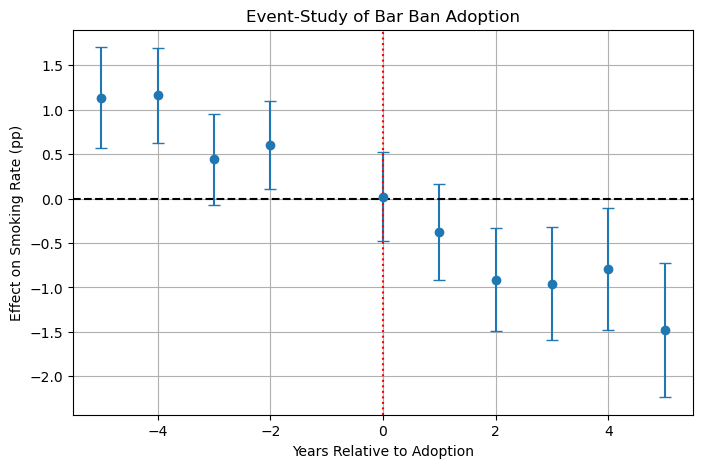

In [76]:
import re
import numpy as np
import matplotlib.pyplot as plt

# extract event-time coefficients
coef_dict = {}
se_dict = {}

for name in model_es.params.index:
    if "event_time_str" in name:
        # extract the number (e.g. T.-3.0)
        match = re.search(r'\[T\.(\-?\d+\.?\d*)\]', name)
        if match:
            k = float(match.group(1))
            coef_dict[k] = model_es.params[name]
            se_dict[k] = model_es.bse[name]

# sort by event time
event_times = sorted(coef_dict.keys())
coefs = [coef_dict[k] for k in event_times]
ses = [se_dict[k] for k in event_times]

# plot
plt.figure(figsize=(8,5))
plt.errorbar(event_times, coefs, yerr=1.96*np.array(ses), fmt='o', capsize=4)
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='red', linestyle=':')
plt.title("Event-Study of Bar Ban Adoption")
plt.xlabel("Years Relative to Adoption")
plt.ylabel("Effect on Smoking Rate (pp)")
plt.grid(True)
plt.show()

In [91]:
import statsmodels.formula.api as smf

# 1. Adoption year for WORKSITE bans
adoption_year_work = (
    df[df["Private_Worksites"] == 1]     # or "Private_Worksites" if you really renamed it
    .groupby("state")["year"]
    .min()
    .rename("adoption_year_work")
)

# 2. Merge into df (no conflict with bar adoption_year)
df = df.merge(adoption_year_work, on="state", how="left")

# 3. Event time for worksite bans
df["event_time_work"] = df["year"] - df["adoption_year_work"]

# 4. Keep only states that ever adopt a worksite ban
df_es = df[df["adoption_year_work"].notna()].copy()

# 5. Make integer and string versions
df_es["event_time_work"] = df_es["event_time_work"].astype(int)
df_es["event_time_str"] = df_es["event_time_work"].astype(str)

baseline = -1
baseline_str = str(baseline)

In [92]:
model_es_work = smf.ols(
    f"smoking_rate ~ C(event_time_str, Treatment(reference='{baseline_str}')) + C(state) + C(year)",
    data=df_es
).fit()

print(model_es_work.summary())

                            OLS Regression Results                            
Dep. Variable:           smoking_rate   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     77.59
Date:                Wed, 10 Dec 2025   Prob (F-statistic):          2.60e-264
Time:                        20:32:15   Log-Likelihood:                -994.00
No. Observations:                 661   AIC:                             2160.
Df Residuals:                     575   BIC:                             2546.
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [94]:
ev = model_es.params[model_es.params.index.str.contains("event_time_str")]
print(ev)

C(event_time_str, Treatment(reference='-1.0'))[T.-2.0]    0.601879
C(event_time_str, Treatment(reference='-1.0'))[T.-3.0]    0.442987
C(event_time_str, Treatment(reference='-1.0'))[T.-4.0]    1.160802
C(event_time_str, Treatment(reference='-1.0'))[T.-5.0]    1.136378
C(event_time_str, Treatment(reference='-1.0'))[T.0.0]     0.019991
C(event_time_str, Treatment(reference='-1.0'))[T.1.0]    -0.379126
C(event_time_str, Treatment(reference='-1.0'))[T.2.0]    -0.910332
C(event_time_str, Treatment(reference='-1.0'))[T.3.0]    -0.956959
C(event_time_str, Treatment(reference='-1.0'))[T.4.0]    -0.792260
C(event_time_str, Treatment(reference='-1.0'))[T.5.0]    -1.479382
dtype: float64
